In [1]:
import scipy.stats as st
import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import random

# import ipynb_importer
# from notebook_Jon import *

In [2]:
optimal_betas_df = pd.read_csv(r'g1.csv',usecols=[1,2,3,4])
optimal_betas_df

,model,lambda,epsilon,beta
0,G1,0.0,0.05,0.742378
1,G1,0.0,0.15,0.470129
2,G1,0.0,0.25,0.343540
3,G1,0.0,0.35,0.260158
4,G1,0.0,0.45,0.197880
...,...,...,...,...
95,G1,1.0,0.55,9.593076
96,G1,1.0,0.65,6.910039
97,G1,1.0,0.75,4.611713
98,G1,1.0,0.85,2.601481


In [3]:
class DatasetGenerator(object):
    def __init__(self, N=100):
        self.N = N
        self.x = None
        self.v = None
        self.refresh()

    def refresh(self):
        raise Exception("undefined")

class G1(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = st.uniform().rvs((self.N,))

class G2(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

In [4]:
class GenerateState():
    def __init__(self,maxSt,g,N):
        self.maxSt = maxSt
        self.g = g
        self.N = N
#         self.S = np.zeros([self.N,])
        self.chosen_city = np.zeros([self.N,])
        self.v = g.v
        self.x = g.x
        self.states = np.zeros([maxSt,self.N])
        
        self.S_cardinality = 0
        self.index = []
        
#     def ChoosenStates(self):
#         self.S = np.random.randint(0,2,size=self.N)
#         return self.S
    
    def ChoosenStates(self):
        self.chosen_city = np.random.randint(0,2,size=self.N)
        return self.chosen_city
        
    def TotalSet(self):
        for iter_ in range(self.maxSt):
            state = self.ChoosenStates()
            self.states[iter_][:] = state
        return self.states
        

In [22]:
class MHevolver():
    def __init__(self, g, lmbd, chosen_city,beta):
        self.g = g
        self.N = g.N
        self.v = g.v
        self.x = g.x
        self.lmbd = lmbd
        self.card = np.size(np.where(chosen_city!=0))
        self.chosen_city = chosen_city
        self.func = 0
        self.vertex = 0
#         self.vertex_value = 0

        
    def calculate_v(self,chosen_city):
        population = self.v[np.where(chosen_city!=0)]
        return population.sum()
        
    def calculate_d(self):
        dist_map = sp.spatial.distance_matrix(self.x, self.x)
        maxd = dist_map.max()
        return maxd
    
    def calculate_f(self,chosen_city):
        self.card = np.size(np.where(chosen_city!=0))
        population = self.calculate_v(chosen_city)
        maxd = self.calculate_d()
        area = np.pi*maxd**2/4
        f = population - self.lmbd*self.card*area
        return f
        
    def evolve(self,chosen_city):
        f_orig = self.calculate_f(chosen_city)
        self.vertex = np.random.choice(range(self.N))
        chosen_city[self.vertex] = int(not self.chosen_city[self.vertex])
        f_evol = self.calculate_f(chosen_city)
        
        accep_prob = np.exp(beta*(f_evol-f_orig))
        accep_prob = min([1,accep_prob])
        
        u = st.uniform().rvs()
        if u<accep_prob:
            self.chosen_city = chosen_city
            self.func = f_evol
        else:
            self.func = f_orig
        
        

In [6]:
def compare(States):
    n_states = len(States)
    score = 0
    
    for iter_ in range(n_states-1):
        city = States[iter_].chosen_city
        city_next = States[iter_+1].chosen_city
        
        if (city == city_next).all():
            score += 1
            
    return score
        
    

In [7]:
lmbd = 1
epsilon = 0.05

In [8]:
maxStates = 10
g = G1()
g.refresh()
N=100
lmbd = 1
epsilon = 0.05
n_iteration = 1000
# mh = MHevolver(g,lmbd,)

score = np.zeros([n_iteration,])

city_track = np.zeros([maxStates,n_iteration,N])
f_track = np.zeros([maxStates,n_iteration])

In [9]:
total_states = GenerateState(maxStates,g,N) 
init_states = total_states.TotalSet()

score = np.zeros([n_iteration,])
for iter_ in range(len(init_states)-1):
        city = init_states[iter_,:]
        city_next = init_states[iter_+1,:]
        
        if (city == city_next).all():
            score[0] += 1
            print('/')
            
print(f"the init similarity between the init states  = {score[0]}")

the init similarity between the init states  = 0.0


In [27]:

#lmbd
end_iter = n_iteration-1
for iter_ in range(n_iteration-1):
    states = list()
    for state in range(maxStates):
        beta = optimal_betas_df.query("(model == 'G1') & (`lambda` == @lmbd) & (epsilon == @epsilon)")['beta'].values[0]
        if iter_ == 0: city_track[state,iter_,:] = init_states[state][:]
        mh = MHevolver(g,lmbd,city_track[state, iter_, :],beta)
        mh.evolve(city)
        states.append(mh)
#         if state in choose_track_city:
#             track = np.where(choose_track_city==state)
#             city_track[track,iter_,:]=mh.chosen_city
#             f_track[track,iter_]=mh.func
        city_track[state,iter_+1,:] = mh.chosen_city
        f_track[state,iter_]=mh.func
    
    score[iter_] = compare(states)
    if np.mod(iter_,10)==0: 
        print("the  similarity of " + str( iter_ +1) + " th iterationthe between states ="+ str(score[iter_]))
    if score[iter_] >= maxStates-1:
        end_iter = iter_
        break
        

the  similarity of 1 th iterationthe between states =3.0
the  similarity of 11 th iterationthe between states =3.0
the  similarity of 21 th iterationthe between states =6.0
the  similarity of 31 th iterationthe between states =5.0
the  similarity of 41 th iterationthe between states =1.0
the  similarity of 51 th iterationthe between states =1.0
the  similarity of 61 th iterationthe between states =3.0
the  similarity of 71 th iterationthe between states =0.0
the  similarity of 81 th iterationthe between states =2.0


In [39]:
n_track = 4
choose_city_index = np.array(random.sample(range(maxStates),n_track))
city_track_choose = city_track[choose_city_index,:,:]

Text(0, 0.5, 'chosen_city index')

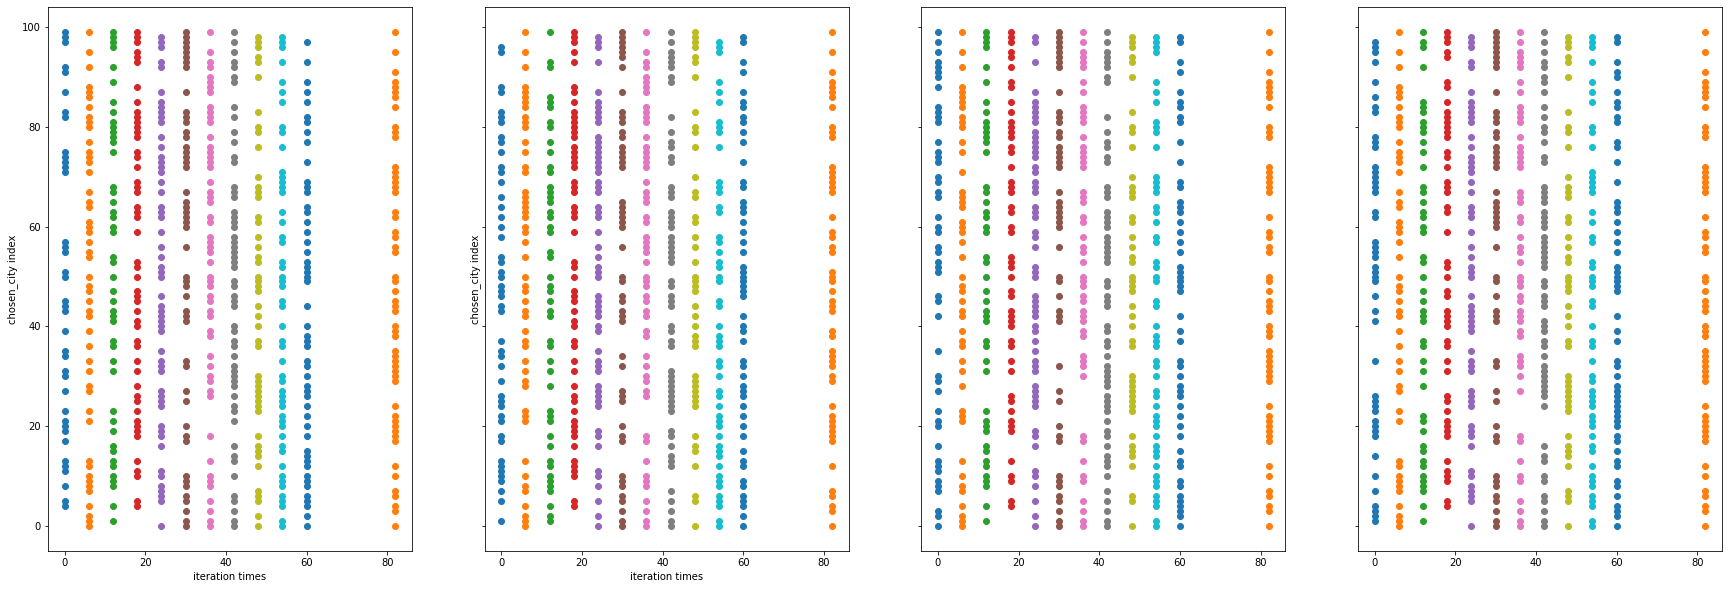

In [41]:
fig, ax = plt.subplots(1,n_track,figsize=(30, 10),sharex=True,sharey=True)
observe_points = 12
city_observe = np.zeros([observe_points,N])
L = int(np.floor(end_iter/observe_points))
for track in range(n_track):
    for iter_ in range(observe_points-1):
        city_observe = city_track_choose[track,iter_*L,:]
        city_observe = np.where(city_observe!=0)
        step = np.array([iter_*L])
        step = step.repeat(np.size(city_observe))
        ax[track].scatter(step,city_observe)
    #plot the last state
    city_observe = city_track_choose[track,end_iter,:]
    city_observe = np.where(city_observe!=0)
    step = np.array([end_iter])
    step = step.repeat(np.size(city_observe))
    ax[track].scatter(step,city_observe)
ax[0].set_xlabel(r'iteration times')
ax[0].set_ylabel(r'chosen_city index')
ax[1].set_xlabel(r'iteration times')
ax[1].set_ylabel(r'chosen_city index')

(81,)
(81,)


Text(0, 0.5, 'value of f')

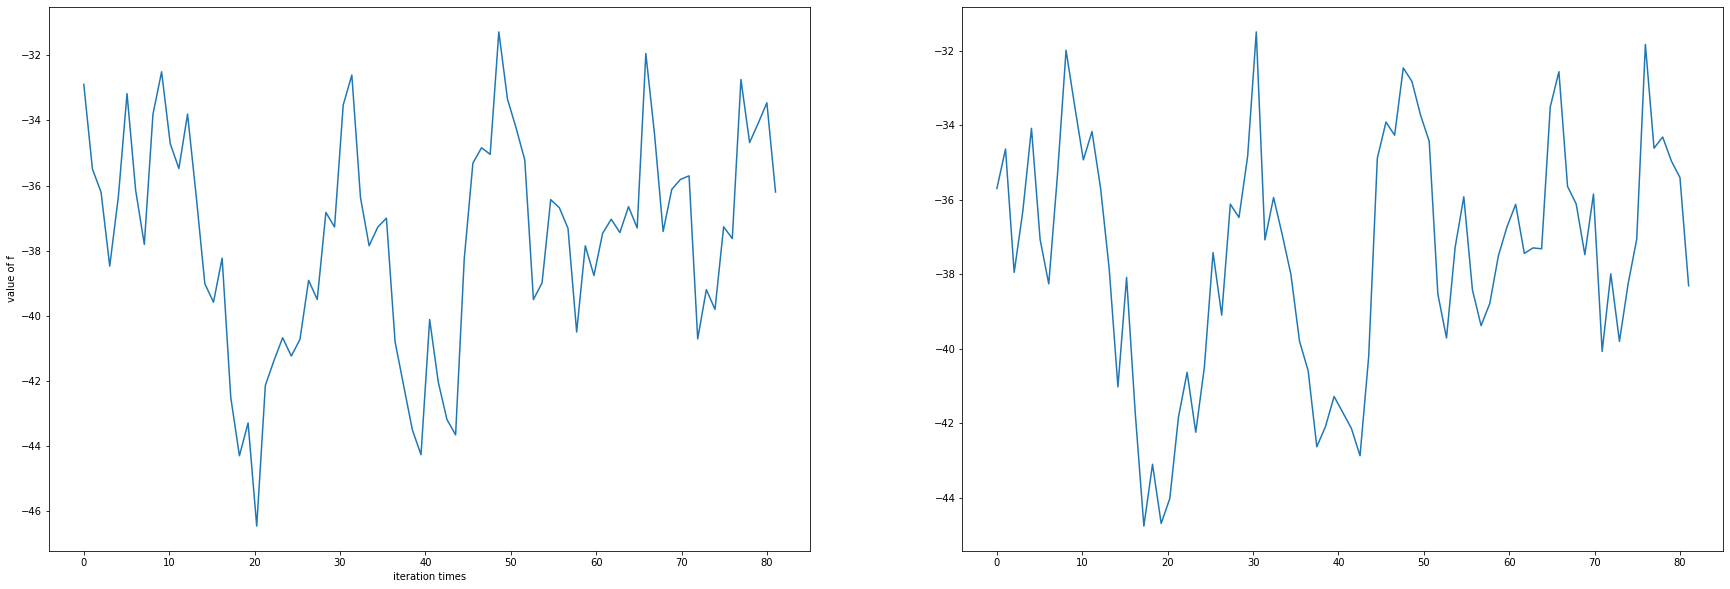

In [42]:
f_track_choose = f_track[choose_city_index,:]
fig, ax2 = plt.subplots(1,2,figsize=(30, 10))
for track in range(2):
        iter_observe = np.linspace(0,end_iter-1,end_iter-1)
        iter_observe = np.transpose(iter_observe)
        f_observe = f_track_choose[track,0:end_iter-1]
        print(f_observe.shape)
        ax2[track].plot(iter_observe,f_observe)
ax2[0].set_xlabel(r'iteration times')
ax2[0].set_ylabel(r'value of f')